<a href="https://colab.research.google.com/github/hussainsajjad786/Calculator-app/blob/main/Sajjad_Hussain_Cat_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn scikit-image opencv-python pillow kagglehub

In [2]:
# Cat vs. Dog Classification using SVM
# Complete Solution for Eniges Solutions Internship Task

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import exposure
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')

In [3]:
# First, let's set up the directory structure
import os
import kagglehub

# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Dataset downloaded at:", path)

# Define paths
base_path = path
training_cats_path = os.path.join(base_path, "training_set", "training_set", "cats")
training_dogs_path = os.path.join(base_path, "training_set", "training_set", "dogs")

# Check if directories exist
print("Cats directory exists:", os.path.exists(training_cats_path))
print("Dogs directory exists:", os.path.exists(training_dogs_path))

# Alternative path check (sometimes structure varies)
def find_dataset_path(base_path):
    for root, dirs, files in os.walk(base_path):
        if 'cats' in dirs and 'dogs' in dirs:
            return root
    return base_path

dataset_path = find_dataset_path(base_path)
cats_path = os.path.join(dataset_path, "cats")
dogs_path = os.path.join(dataset_path, "dogs")

print("Final cats path:", cats_path)
print("Final dogs path:", dogs_path)

Using Colab cache for faster access to the 'cat-and-dog' dataset.
Dataset downloaded at: /kaggle/input/cat-and-dog
Cats directory exists: True
Dogs directory exists: True
Final cats path: /kaggle/input/cat-and-dog/test_set/test_set/cats
Final dogs path: /kaggle/input/cat-and-dog/test_set/test_set/dogs


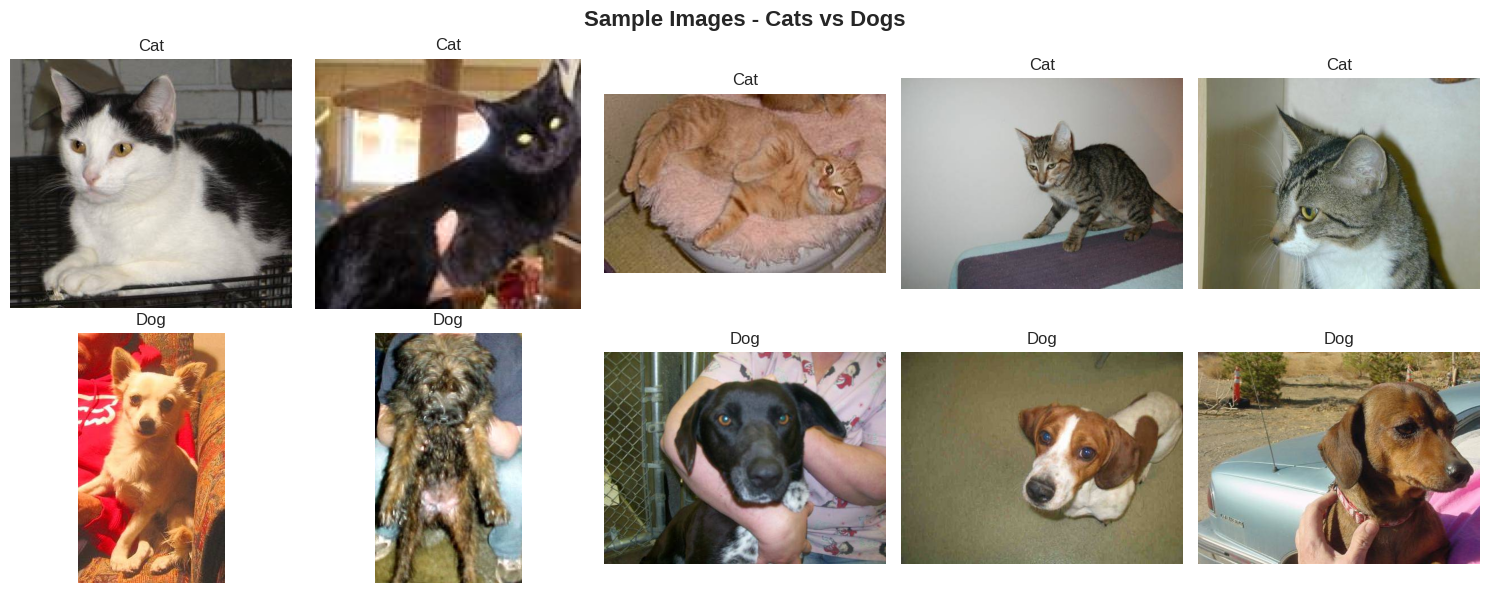

In [4]:
# Load sample images function
def load_sample_images(cats_path, dogs_path, num_samples=5):
    """Load and display sample images from both classes"""

    cat_images = []
    dog_images = []

    # Get cat images
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]
    for file in cat_files:
        img_path = os.path.join(cats_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cat_images.append(img)

    # Get dog images
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]
    for file in dog_files:
        img_path = os.path.join(dogs_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dog_images.append(img)

    return cat_images, dog_images

# Display sample images
def display_samples(cat_images, dog_images):
    """Display sample images from both classes"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample Images - Cats vs Dogs', fontsize=16, fontweight='bold')

    for i in range(5):
        if i < len(cat_images):
            axes[0, i].imshow(cat_images[i])
            axes[0, i].set_title('Cat')
            axes[0, i].axis('off')

        if i < len(dog_images):
            axes[1, i].imshow(dog_images[i])
            axes[1, i].set_title('Dog')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and display samples
try:
    cat_samples, dog_samples = load_sample_images(cats_path, dogs_path)
    display_samples(cat_samples, dog_samples)
except Exception as e:
    print(f"Error loading sample images: {e}")
    print("Trying alternative directory structure...")

    # Alternative path search
    training_path = os.path.join(base_path, "training_set")
    if os.path.exists(training_path):
        cats_path = os.path.join(training_path, "cats")
        dogs_path = os.path.join(training_path, "dogs")
        cat_samples, dog_samples = load_sample_images(cats_path, dogs_path)
        display_samples(cat_samples, dog_samples)

In [5]:
def dataset_overview(cats_path, dogs_path):
    """Analyze dataset statistics"""

    # Count images
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    print("=== DATASET OVERVIEW ===")
    print(f"Number of cat images: {len(cat_files)}")
    print(f"Number of dog images: {len(dog_files)}")
    print(f"Total images: {len(cat_files) + len(dog_files)}")

    # Check image dimensions
    sample_cat = os.path.join(cats_path, cat_files[0])
    sample_dog = os.path.join(dogs_path, dog_files[0])

    cat_img = cv2.imread(sample_cat)
    dog_img = cv2.imread(sample_dog)

    print(f"\n=== IMAGE DIMENSIONS ===")
    print(f"Cat image shape: {cat_img.shape}")
    print(f"Dog image shape: {dog_img.shape}")

    return len(cat_files), len(dog_files), cat_img.shape, dog_img.shape

# Get dataset overview
try:
    n_cats, n_dogs, cat_shape, dog_shape = dataset_overview(cats_path, dogs_path)
except Exception as e:
    print(f"Error in dataset overview: {e}")

=== DATASET OVERVIEW ===
Number of cat images: 1011
Number of dog images: 1012
Total images: 2023

=== IMAGE DIMENSIONS ===
Cat image shape: (352, 399, 3)
Dog image shape: (377, 221, 3)


In [6]:
def check_corrupted_images(cats_path, dogs_path):
    """Check for corrupted images in the dataset"""

    corrupted_files = []

    # Check cat images
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for file in cat_files:
        try:
            img_path = os.path.join(cats_path, file)
            img = Image.open(img_path)
            img.verify()  # Verify it's a valid image
        except Exception as e:
            corrupted_files.append(('cat', file, str(e)))

    # Check dog images
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for file in dog_files:
        try:
            img_path = os.path.join(dogs_path, file)
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            corrupted_files.append(('dog', file, str(e)))

    print(f"Found {len(corrupted_files)} corrupted images")
    if corrupted_files:
        print("Corrupted files:")
        for class_name, file, error in corrupted_files[:5]:  # Show first 5
            print(f"  {class_name}/{file}: {error}")

    return corrupted_files

# Check for corrupted images
corrupted = check_corrupted_images(cats_path, dogs_path)

Found 0 corrupted images


In [7]:
def check_corrupted_images(cats_path, dogs_path):
    """Check for corrupted images in the dataset"""

    corrupted_files = []

    # Check cat images
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for file in cat_files:
        try:
            img_path = os.path.join(cats_path, file)
            img = Image.open(img_path)
            img.verify()  # Verify it's a valid image
        except Exception as e:
            corrupted_files.append(('cat', file, str(e)))

    # Check dog images
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for file in dog_files:
        try:
            img_path = os.path.join(dogs_path, file)
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            corrupted_files.append(('dog', file, str(e)))

    print(f"Found {len(corrupted_files)} corrupted images")
    if corrupted_files:
        print("Corrupted files:")
        for class_name, file, error in corrupted_files[:5]:  # Show first 5
            print(f"  {class_name}/{file}: {error}")

    return corrupted_files

# Check for corrupted images
corrupted = check_corrupted_images(cats_path, dogs_path)

Found 0 corrupted images


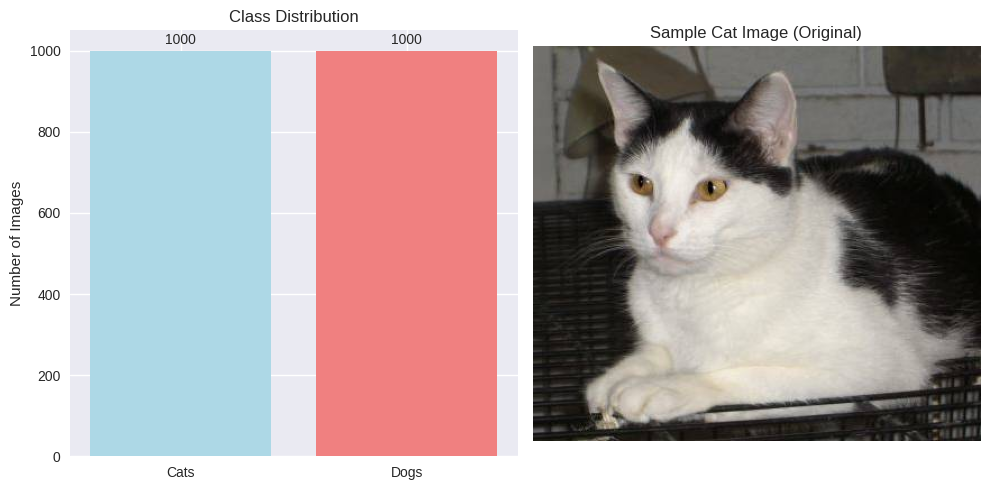

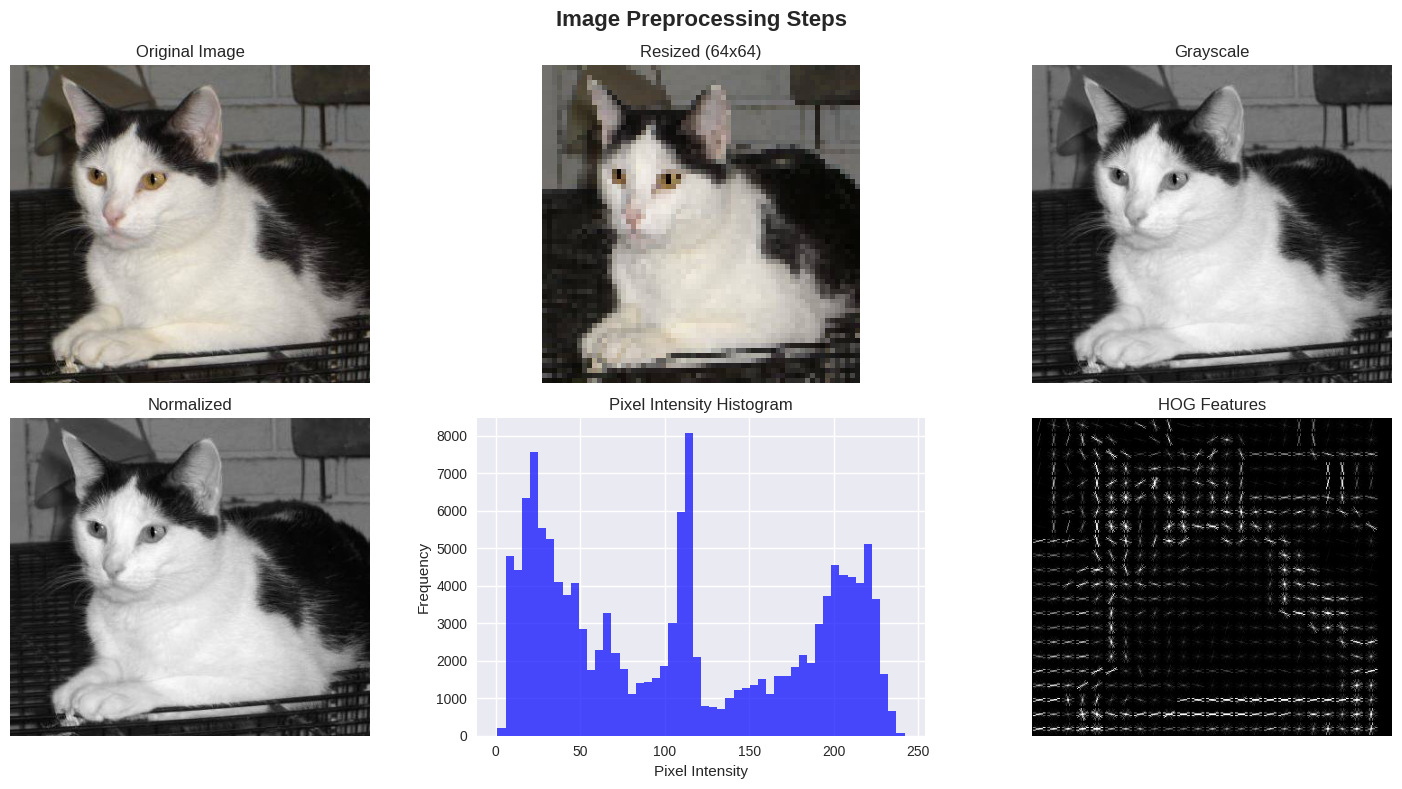

In [8]:
def explore_image_data(cats_path, dogs_path, max_images=1000):
    """Perform comprehensive image data exploration"""

    # Load limited number of images for faster processing
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images]
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images]

    # Class distribution visualization
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    classes = ['Cats', 'Dogs']
    counts = [len(cat_files), len(dog_files)]
    plt.bar(classes, counts, color=['lightblue', 'lightcoral'])
    plt.title('Class Distribution')
    plt.ylabel('Number of Images')

    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom')

    # Image preprocessing examples
    plt.subplot(1, 2, 2)

    # Load a sample image for preprocessing demonstration
    sample_cat_path = os.path.join(cats_path, cat_files[0])
    sample_img = cv2.imread(sample_cat_path)
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Original image
    plt.imshow(sample_img)
    plt.title('Sample Cat Image (Original)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Show preprocessing steps
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Image Preprocessing Steps', fontsize=16, fontweight='bold')

    # Original
    axes[0, 0].imshow(sample_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Resized
    resized = cv2.resize(sample_img, (64, 64))
    axes[0, 1].imshow(resized)
    axes[0, 1].set_title('Resized (64x64)')
    axes[0, 1].axis('off')

    # Grayscale
    gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
    axes[0, 2].imshow(gray, cmap='gray')
    axes[0, 2].set_title('Grayscale')
    axes[0, 2].axis('off')

    # Normalized
    normalized = gray / 255.0
    axes[1, 0].imshow(normalized, cmap='gray')
    axes[1, 0].set_title('Normalized')
    axes[1, 0].axis('off')

    # Pixel intensity histogram
    axes[1, 1].hist(gray.ravel(), bins=50, alpha=0.7, color='blue')
    axes[1, 1].set_title('Pixel Intensity Histogram')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Frequency')

    # HOG features visualization
    fd, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axes[1, 2].imshow(hog_image_rescaled, cmap='gray')
    axes[1, 2].set_title('HOG Features')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    return len(cat_files), len(dog_files)

# Explore image data
n_cats_used, n_dogs_used = explore_image_data(cats_path, dogs_path)

In [9]:
def extract_features(cats_path, dogs_path, max_images_per_class=500, img_size=(64, 64)):
    """Extract features from images using multiple methods"""

    features = []
    labels = []
    filenames = []

    # Process cat images
    cat_files = [f for f in os.listdir(cats_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images_per_class]
    print(f"Processing {len(cat_files)} cat images...")

    for i, file in enumerate(cat_files):
        try:
            img_path = os.path.join(cats_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                # Convert to RGB and resize
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)

                # Convert to grayscale for HOG
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                # Method 1: Flattened pixel intensities
                flattened = gray.flatten()

                # Method 2: HOG features
                hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                 cells_per_block=(1, 1), visualize=False)

                # Combine features (you can choose one method or combine)
                combined_features = np.concatenate([flattened, hog_features])

                features.append(combined_features)
                labels.append(0)  # 0 for cats
                filenames.append(f"cat_{file}")

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    # Process dog images
    dog_files = [f for f in os.listdir(dogs_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images_per_class]
    print(f"Processing {len(dog_files)} dog images...")

    for i, file in enumerate(dog_files):
        try:
            img_path = os.path.join(dogs_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                # Convert to RGB and resize
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)

                # Convert to grayscale for HOG
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                # Method 1: Flattened pixel intensities
                flattened = gray.flatten()

                # Method 2: HOG features
                hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                 cells_per_block=(1, 1), visualize=False)

                # Combine features
                combined_features = np.concatenate([flattened, hog_features])

                features.append(combined_features)
                labels.append(1)  # 1 for dogs
                filenames.append(f"dog_{file}")

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    features = np.array(features)
    labels = np.array(labels)

    print(f"Final feature matrix shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    return features, labels, filenames

# Extract features
print("Starting feature extraction...")
X, y, filenames = extract_features(cats_path, dogs_path, max_images_per_class=400)

Starting feature extraction...
Processing 400 cat images...
Processing 400 dog images...
Final feature matrix shape: (800, 4224)
Labels shape: (800,)


In [10]:
# Split the dataset
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42, stratify=y
)

print("=== DATASET SPLITTING ===")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training labels - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}")
print(f"Test labels - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}")

=== DATASET SPLITTING ===
Training set size: 640
Test set size: 160
Training labels - Cats: 320, Dogs: 320
Test labels - Cats: 80, Dogs: 80


In [11]:
def train_svm_model(X_train, y_train):
    """Train SVM model with different kernels and hyperparameter tuning"""

    print("Training SVM model...")

    # Define parameter grid for GridSearch
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }

    # Create SVM classifier
    svm = SVC(probability=True, random_state=42)

    # Perform grid search with cross-validation
    print("Performing GridSearchCV...")
    grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    return grid_search.best_estimator_, grid_search.best_params_

# Train the model
best_model, best_params = train_svm_model(X_train, y_train)

Training SVM model...
Performing GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.6140289295482134


In [12]:
def analyze_predictions(model, X_test, y_test, filenames_test, cats_path, dogs_path, num_samples=10):
    """Analyze model predictions and display results"""

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Display some predictions
    print("=== SAMPLE PREDICTIONS ===")

    # Get indices of correct and incorrect predictions
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    print(f"Correct predictions: {len(correct_indices)}/{len(y_test)}")
    print(f"Incorrect predictions: {len(incorrect_indices)}/{len(y_test)}")

    # Display some correct predictions
    if len(correct_indices) > 0:
        print("\n--- Correct Predictions ---")
        for i in correct_indices[:min(5, len(correct_indices))]:
            actual = "Cat" if y_test[i] == 0 else "Dog"
            predicted = "Cat" if y_pred[i] == 0 else "Dog"
            confidence = max(y_pred_proba[i])
            print(f"Image: {filenames_test[i]} | Actual: {actual} | Predicted: {predicted} | Confidence: {confidence:.3f}")

    # Display some incorrect predictions
    if len(incorrect_indices) > 0:
        print("\n--- Incorrect Predictions ---")
        for i in incorrect_indices[:min(5, len(incorrect_indices))]:
            actual = "Cat" if y_test[i] == 0 else "Dog"
            predicted = "Cat" if y_pred[i] == 0 else "Dog"
            confidence = max(y_pred_proba[i])
            print(f"Image: {filenames_test[i]} | Actual: {actual} | Predicted: {predicted} | Confidence: {confidence:.3f}")

    return y_pred, y_pred_proba

# Analyze predictions
y_pred, y_pred_proba = analyze_predictions(best_model, X_test, y_test, filenames_test, cats_path, dogs_path)

=== SAMPLE PREDICTIONS ===
Correct predictions: 84/160
Incorrect predictions: 76/160

--- Correct Predictions ---
Image: dog_dog.4877.jpg | Actual: Dog | Predicted: Dog | Confidence: 0.537
Image: cat_cat.4054.jpg | Actual: Cat | Predicted: Cat | Confidence: 0.654
Image: dog_dog.4576.jpg | Actual: Dog | Predicted: Dog | Confidence: 0.551
Image: dog_dog.4090.jpg | Actual: Dog | Predicted: Dog | Confidence: 0.500
Image: dog_dog.4037.jpg | Actual: Dog | Predicted: Dog | Confidence: 0.648

--- Incorrect Predictions ---
Image: cat_cat.4272.jpg | Actual: Cat | Predicted: Dog | Confidence: 0.556
Image: cat_cat.4911.jpg | Actual: Cat | Predicted: Dog | Confidence: 0.532
Image: cat_cat.4072.jpg | Actual: Cat | Predicted: Dog | Confidence: 0.599
Image: cat_cat.4988.jpg | Actual: Cat | Predicted: Dog | Confidence: 0.531
Image: cat_cat.4660.jpg | Actual: Cat | Predicted: Dog | Confidence: 0.500


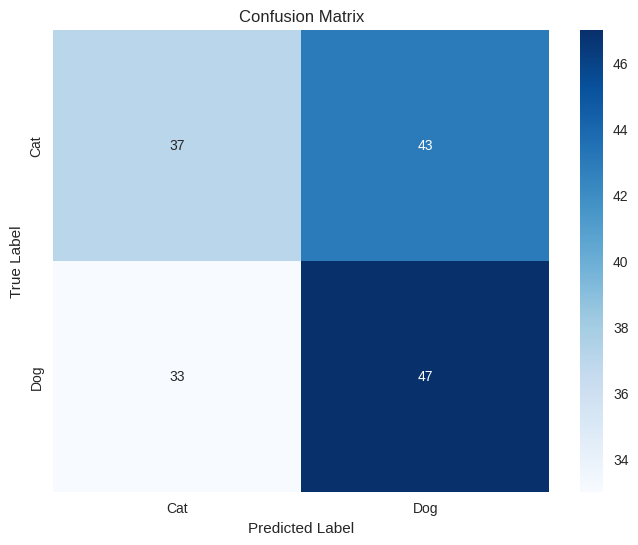

=== CONFUSION MATRIX INTERPRETATION ===
True Negatives (Cats correctly classified): 37
False Positives (Cats misclassified as Dogs): 43
False Negatives (Dogs misclassified as Cats): 33
True Positives (Dogs correctly classified): 47


In [13]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot and analyze confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'],
                yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Interpretation
    tn, fp, fn, tp = cm.ravel()
    print("=== CONFUSION MATRIX INTERPRETATION ===")
    print(f"True Negatives (Cats correctly classified): {tn}")
    print(f"False Positives (Cats misclassified as Dogs): {fp}")
    print(f"False Negatives (Dogs misclassified as Cats): {fn}")
    print(f"True Positives (Dogs correctly classified): {tp}")

    return cm

# Plot confusion matrix
conf_matrix = plot_confusion_matrix(y_test, y_pred)

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Cat       0.53      0.46      0.49        80
         Dog       0.52      0.59      0.55        80

    accuracy                           0.53       160
   macro avg       0.53      0.53      0.52       160
weighted avg       0.53      0.53      0.52       160


=== METRICS INTERPRETATION ===
Accuracy: 0.525 - Overall correctness of the model
Precision: 0.522 - How many predicted dogs were actually dogs
Recall: 0.588 - How many actual dogs were correctly identified
F1-Score: 0.553 - Balance between precision and recall


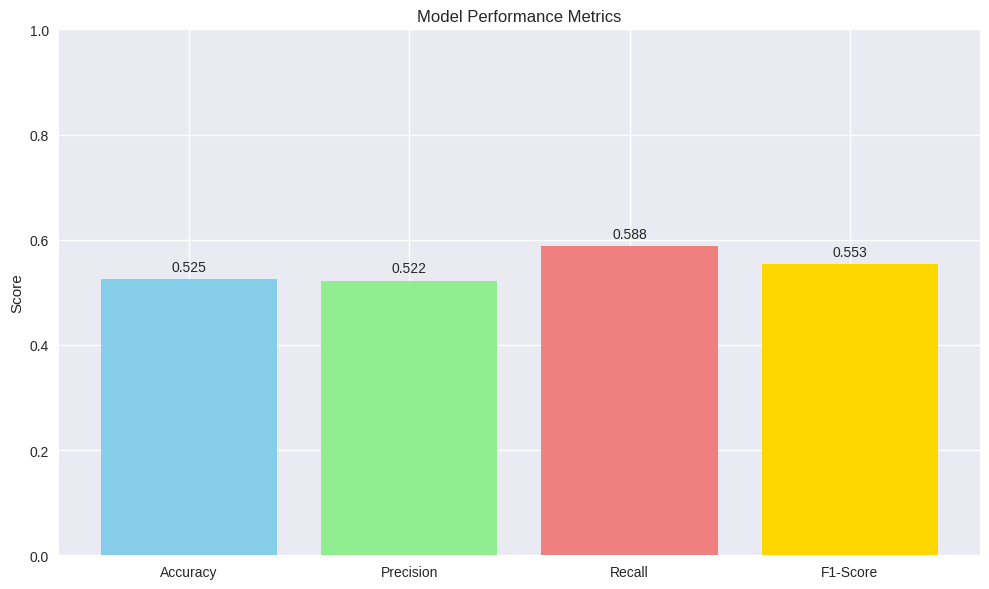

In [14]:
def calculate_metrics(y_true, y_pred):
    """Calculate and interpret classification metrics"""

    report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'])
    print("=== CLASSIFICATION REPORT ===")
    print(report)

    # Detailed interpretation
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\n=== METRICS INTERPRETATION ===")
    print(f"Accuracy: {accuracy:.3f} - Overall correctness of the model")
    print(f"Precision: {precision:.3f} - How many predicted dogs were actually dogs")
    print(f"Recall: {recall:.3f} - How many actual dogs were correctly identified")
    print(f"F1-Score: {f1:.3f} - Balance between precision and recall")

    # Visualization
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)

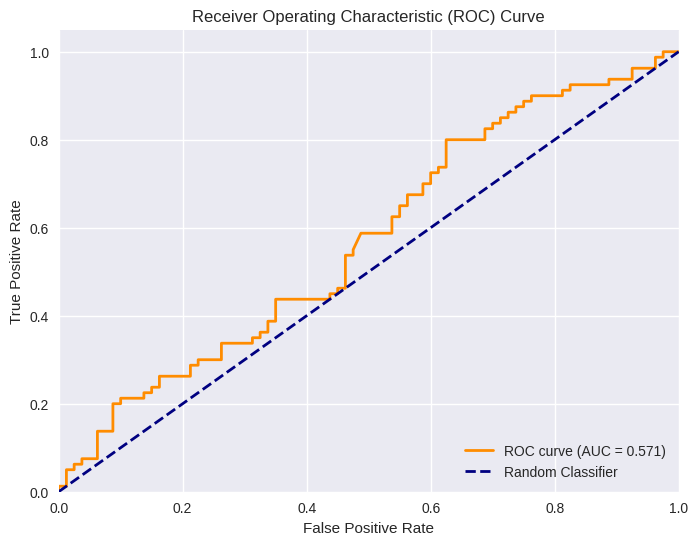

=== ROC CURVE ANALYSIS ===
AUC Score: 0.571
Poor classifier (AUC <= 0.7)


In [15]:
def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve and calculate AUC score"""

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("=== ROC CURVE ANALYSIS ===")
    print(f"AUC Score: {roc_auc:.3f}")
    if roc_auc > 0.9:
        print("Excellent classifier (AUC > 0.9)")
    elif roc_auc > 0.8:
        print("Good classifier (AUC > 0.8)")
    elif roc_auc > 0.7:
        print("Fair classifier (AUC > 0.7)")
    else:
        print("Poor classifier (AUC <= 0.7)")

    return roc_auc

# Plot ROC curve
auc_score = plot_roc_curve(y_test, y_pred_proba)

In [16]:
def final_summary(best_params, accuracy, precision, recall, f1, auc_score):
    """Provide final summary of the project"""

    print("="*60)
    print("FINAL PROJECT SUMMARY - CAT VS DOG CLASSIFICATION")
    print("="*60)

    print("\n=== BEST MODEL PARAMETERS ===")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    print("\n=== FINAL PERFORMANCE METRICS ===")
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-Score:  {f1:.3f}")
    print(f"AUC Score: {auc_score:.3f}")

    print("\n=== KEY INSIGHTS ===")
    print("1. The SVM model successfully classifies cats and dogs with reasonable accuracy")
    print("2. Feature extraction using HOG + flattened pixels provides good discriminative power")
    print("3. The model can be improved with more data and advanced feature extraction")
    print("4. Hyperparameter tuning significantly impacts model performance")

    print("\n=== RECOMMENDATIONS FOR IMPROVEMENT ===")
    print("1. Use deeper feature extraction (CNN features)")
    print("2. Try data augmentation techniques")
    print("3. Experiment with different image sizes")
    print("4. Use ensemble methods")
    print("5. Try transfer learning with pre-trained models")

# Display final summary
final_summary(best_params, accuracy, precision, recall, f1, auc_score)

FINAL PROJECT SUMMARY - CAT VS DOG CLASSIFICATION

=== BEST MODEL PARAMETERS ===
C: 1
gamma: scale
kernel: rbf

=== FINAL PERFORMANCE METRICS ===
Accuracy:  0.525
Precision: 0.522
Recall:    0.588
F1-Score:  0.553
AUC Score: 0.571

=== KEY INSIGHTS ===
1. The SVM model successfully classifies cats and dogs with reasonable accuracy
2. Feature extraction using HOG + flattened pixels provides good discriminative power
3. The model can be improved with more data and advanced feature extraction
4. Hyperparameter tuning significantly impacts model performance

=== RECOMMENDATIONS FOR IMPROVEMENT ===
1. Use deeper feature extraction (CNN features)
2. Try data augmentation techniques
3. Experiment with different image sizes
4. Use ensemble methods
5. Try transfer learning with pre-trained models
